In [157]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import tensorflow.keras
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dropout, Dense, SimpleRNN
from tensorflow.keras import backend as K
from tensorflow.keras.layers import LSTM 
from tensorflow.keras.models import Sequential
import time
%matplotlib inline

dataset = pd.read_csv(r'E:\Datasets-2020.11.6\5.0-Site_31-TDG.csv')

dataset = dataset.rename(columns={
    u'31 TDG - Active Energy Delivered-Received (kWh)': 'AE_Power',
    u'31 TDG - Current Phase Average (A)': 'Current', #电流
    u'31 TDG - Active Power (kW)': 'Power',   #功率
    u'31 TDG - Performance Ratio (%)': 'PR',   #性能比
    u'31 TDG - Wind Speed (m/s)': 'WindSpeed',    #风速
    u'31 TDG - Weather Temperature': 'Temp', #气温
    u'31 TDG - Weather Relative Humidity (%)': 'Humidaty',   #相对湿度
    u'31 TDG - Global Horizontal Radiation': 'GHI',   #全球水平辐照度
    u'31 TDG - Diffuse Horizontal Radiation': 'DHI',  #扩散水平辐射
    u'31 TDG - Wind Direction (Degrees)': 'WD',  #风向
    u'31 TDG - Weather Daily Rainfall (mm)':'RF',#降雨
})

dataset = dataset.drop(['AE_Power','Current','PR','WindSpeed','WD','RF'],axis=1)#删除列,直接是列名

dataset = dataset.dropna(subset=['Power'])# 删除功率为空的数据组

dataset = dataset.fillna(0) # 所有NAN值赋0

dataset = dataset.drop(dataset[dataset.Power < 0].index)
dataset = dataset.drop(dataset[(dataset.Temp > 2000)|(dataset.Temp < 0)].index)
dataset = dataset.drop(dataset[dataset.Humidaty < 0].index)
dataset = dataset.drop(dataset[(dataset.GHI > 2000)|(dataset.GHI < 0)].index)
dataset = dataset.drop(dataset[dataset.DHI < 0].index)

df14 = pd.read_csv(r'E:\Datasets-2020.11.6\uv-alice-springs-2014.csv')
df15 = pd.read_csv(r'E:\Datasets-2020.11.6\uv-alice-springs-2015.csv')
df16 = pd.read_csv(r'E:\Datasets-2020.11.6\uv-alice-springs-2016.csv')
df17 = pd.read_csv(r'E:\Datasets-2020.11.6\uv-alice-springs-2017.csv')
df18 = pd.read_csv(r'E:\Datasets-2020.11.6\uv-alice-springs-2018.csv')
df19 = pd.read_csv(r'E:\Datasets-2020.11.6\uv-alice-springs-2019.csv')

df14['timestamp'] = pd.to_datetime(df14['timestamp'])
df15['timestamp'] = pd.to_datetime(df15['timestamp'])
df16['timestamp'] = pd.to_datetime(df16['timestamp'])
df17['timestamp'] = pd.to_datetime(df17['timestamp'])
df18['timestamp'] = pd.to_datetime(df18['timestamp'])
df19['timestamp'] = pd.to_datetime(df19['timestamp'])
dataset['timestamp'] = pd.to_datetime(dataset['timestamp'])

df = pd.concat([df14,df15,df16,df17,df18,df19],axis=0) #axis=0表示按行操作
df = df.drop(['Lat','Lon'],axis=1)

dataset_n = pd.merge(dataset,df,how='left',on='timestamp')

dataset_n = dataset_n.dropna(subset=['UV_Index'])
dataset_n = dataset_n.drop(dataset_n[dataset_n.UV_Index < 0].index)

In [284]:
training_set = dataset_n.iloc[0:518688,1:7].values 
test_set = dataset_n.iloc[568750:576526,1:7].values 

sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
test_set_scaled=sc.transform(test_set)


x_train = np.array(training_set_scaled[:,1:6]) 
y_train = np.array(training_set_scaled[:,0:1]) 
x_test = np.array(test_set_scaled[:,1:6])
y_test = np.array(test_set_scaled[:,0:1])

np.random.seed(110)
np.random.shuffle(x_train)
np.random.seed(110)
np.random.shuffle(y_train)
tf.random.set_seed(110)

model = tf.keras.Sequential([
    Dense(5,activation='relu',use_bias=True,bias_initializer='ones'),
    Dense(5,activation='relu',use_bias=True,bias_initializer='ones'),
    Dense(1,use_bias=True)
])

#自定义metric函数

def MACU(y_true, y_pred):
    return 1-K.mean(abs(y_true-y_pred)/K.mean(y_true))

def customized_loss(y_true, y_pred):
    return (abs(y_pred[0:288]-y_true[0:288]))

start = time.process_time()
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.2, nesterov=True),loss=customized_loss,metrics=[MACU])

Train on 389016 samples, validate on 129672 samples
Epoch 1/20
389016/389016 [==============================] - 2s 6us/sample - loss: 0.0823 - MACU: 0.6322 - val_loss: 0.0525 - val_MACU: 0.7659
Epoch 2/20
389016/389016 [==============================] - 2s 4us/sample - loss: 0.0441 - MACU: 0.8040 - val_loss: 0.0367 - val_MACU: 0.8369
Epoch 3/20
389016/389016 [==============================] - 2s 4us/sample - loss: 0.0424 - MACU: 0.8113 - val_loss: 0.0556 - val_MACU: 0.7524
Epoch 4/20
389016/389016 [==============================] - 2s 4us/sample - loss: 0.0420 - MACU: 0.8131 - val_loss: 0.0337 - val_MACU: 0.8504
Epoch 5/20
389016/389016 [==============================] - 2s 4us/sample - loss: 0.0418 - MACU: 0.8138 - val_loss: 0.0417 - val_MACU: 0.8144
Epoch 6/20
389016/389016 [==============================] - 2s 4us/sample - loss: 0.0412 - MACU: 0.8167 - val_loss: 0.0318 - val_MACU: 0.8589
Epoch 7/20
389016/389016 [==============================] - 2s 4us/sample - loss: 0.0403 - MACU:

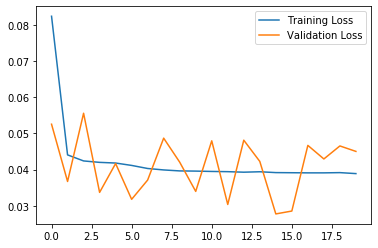

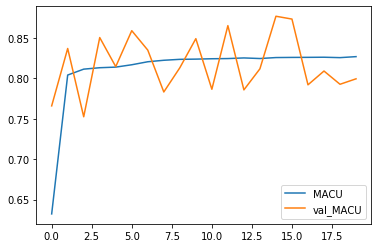

In [285]:
history=model.fit(x_train,y_train,batch_size=288,epochs=20,verbose=1,validation_split=0.25,shuffle=True, validation_freq=1) 
end = time.process_time()

print('Training Duration: ',end - start)

model.summary()

loss=history.history['loss']
val_loss=history.history['val_loss']
Metric=history.history['MACU']
val_Metric=history.history['val_MACU']

plt.plot(loss,label='Training Loss')
plt.plot(val_loss,label='Validation Loss')
plt.legend()
plt.show()

plt.plot(Metric,label='MACU')
plt.plot(val_Metric,label='val_MACU')
plt.legend()
plt.show()

p_y_test_sc = model.predict(x_test)
test_set_p = test_set
test_set_p = np.array(test_set_p)
test_set_p[:,0:1] = p_y_test_sc
p_y_test = sc.inverse_transform(test_set_p)

In [286]:
p_y_test_sc = model.predict(x_test)
test_set_p = test_set
test_set_p = np.array(test_set_p)
test_set_p[:,0:1] = p_y_test_sc
p_y_test = sc.inverse_transform(test_set_p)

In [287]:
day_pred=[]
day_test=[]
for n in range(0,7776,288):
    day_pred.append(p_y_test[n:n+288,0:1].sum())
    day_test.append(test_set[n:n+288,0:1].sum())
print(np.array(day_pred))
print(np.array(day_test))

[489.15749061 467.25536163 463.49625143 456.00333393 457.27415607
 451.77698772 363.35599681 443.05457283 427.19564485 389.34298348
 492.81533576 477.87930352 427.00524953 405.99172025 381.37961875
 320.61952138 420.40734897 404.78447407 423.34372119 415.06454359
 407.27145471 432.76017038 436.19474642 362.85183062 388.31745349
 375.54825764 410.83825428]
[339.31959779 325.995199   327.8558002  325.52179999 323.9334643
 320.34166656 259.00646787 320.09906959 302.521469   250.8036724
 341.53793321 331.84566858 305.30006517 304.51423248 279.78539863
 229.19674543 308.36033354 296.64780074 310.05000099 306.86733202
 297.54679787 313.92419645 314.68793454 263.54239919 279.30946914
 270.70099803 294.67433371]


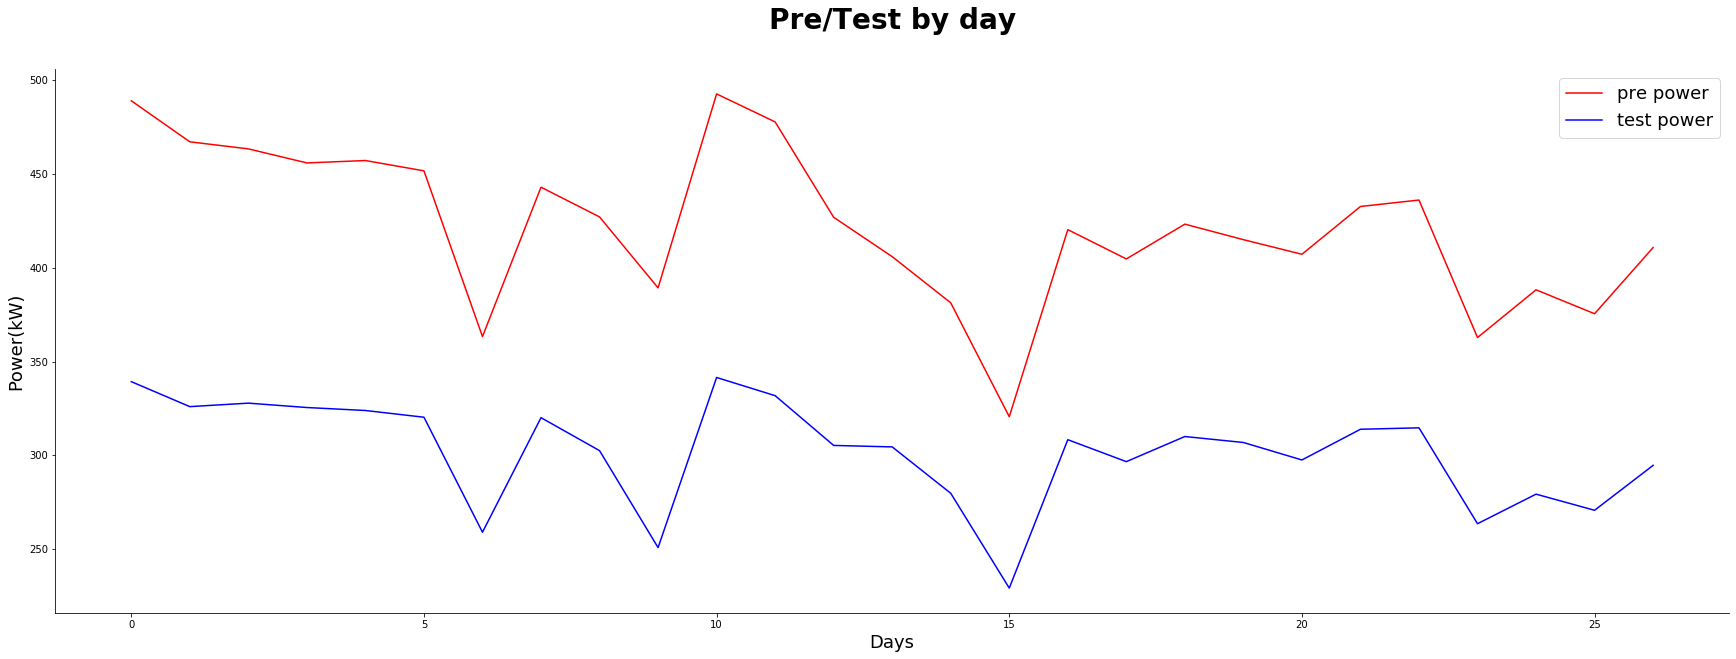

In [288]:
plt.figure(figsize=(30,10))
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.plot(day_pred,color='red',label='pre power')
plt.plot(np.array(day_test),color='blue',label='test power')
plt.title('Pre/Test by day',fontsize=28,fontweight='heavy', pad=40)
plt.xlabel('Days',fontsize=18)
plt.ylabel('Power(kW)',fontsize=18)
plt.legend(fontsize=18)
plt.show()

In [289]:
1-abs((np.array(day_pred))-np.array(day_test))/np.array(day_test)

array([0.55841663, 0.56668024, 0.58628015, 0.59916192, 0.58837012,
       0.5897027 , 0.59711613, 0.61588297, 0.58788321, 0.44761849,
       0.55706998, 0.55993509, 0.6013588 , 0.66675617, 0.6368852 ,
       0.6011166 , 0.63663609, 0.63547118, 0.63459532, 0.64741372,
       0.63123563, 0.6214501 , 0.61388157, 0.62317475, 0.60972328,
       0.6126824 , 0.60578881])

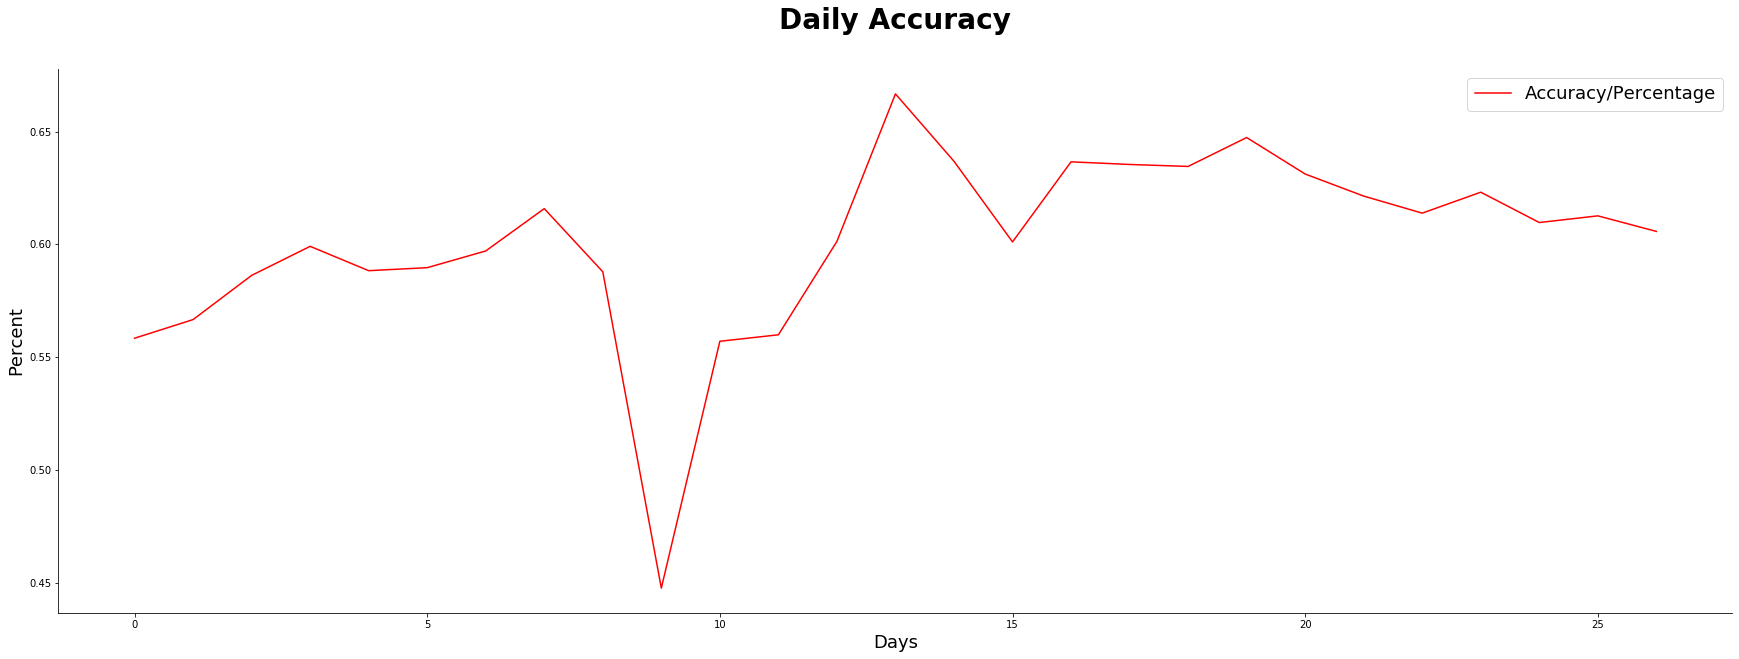

In [290]:
plt.figure(figsize=(30,10))
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.plot(1-abs((np.array(day_pred))-np.array(day_test))/np.array(day_test),color='red',label='Accuracy/Percentage')
plt.title('Daily Accuracy',fontsize=28,fontweight='heavy', pad=40)
plt.xlabel('Days',fontsize=18)
plt.ylabel('Percent',fontsize=18)
plt.legend(fontsize=18)
plt.show()

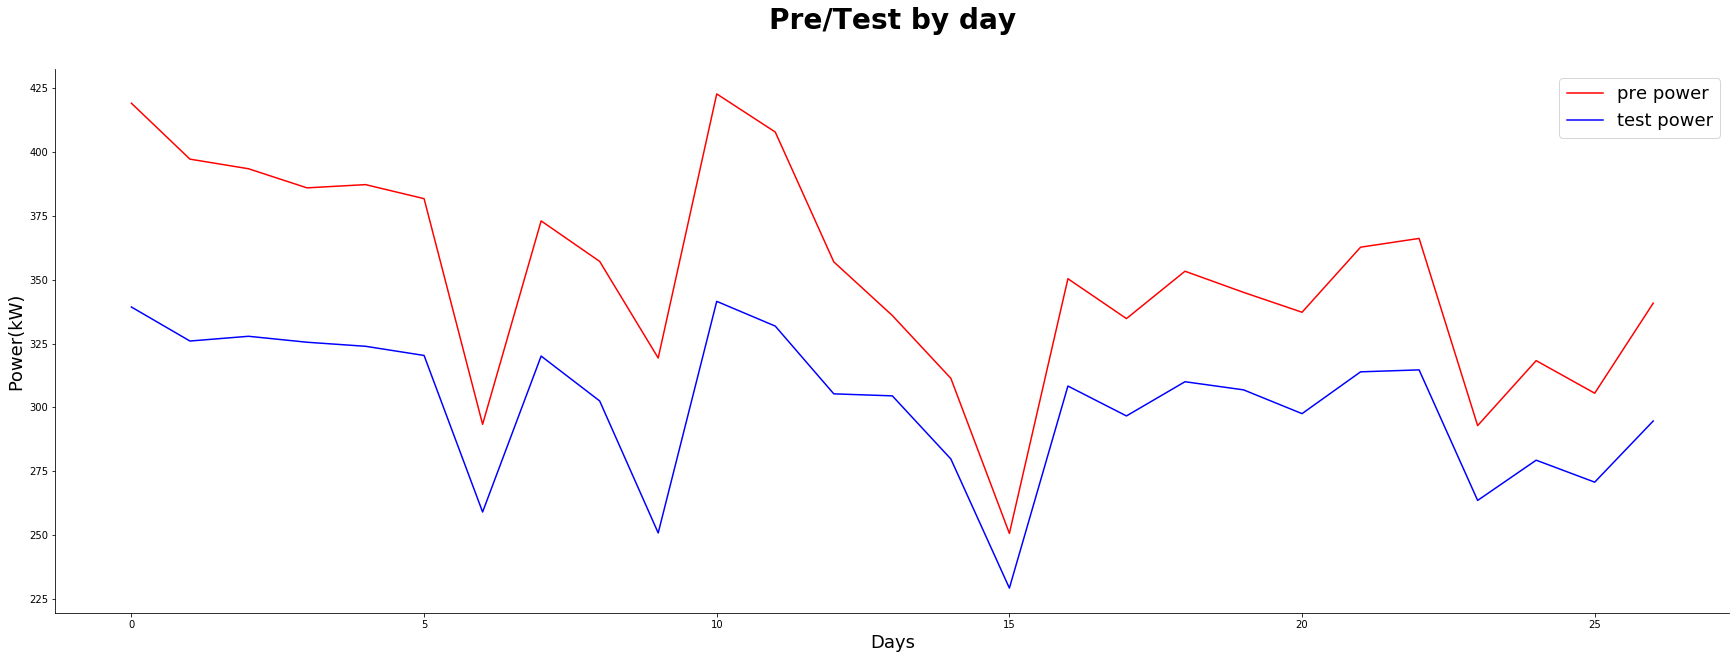

In [291]:
plt.figure(figsize=(30,10))
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.plot(np.array(day_pred)-70,color='red',label='pre power')
plt.plot(np.array(day_test),color='blue',label='test power')
plt.title('Pre/Test by day',fontsize=28,fontweight='heavy', pad=40)
plt.xlabel('Days',fontsize=18)
plt.ylabel('Power(kW)',fontsize=18)
plt.legend(fontsize=18)
plt.show()